In [1]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib
import os
import torch.nn as nn
import optuna
from lightgbm import LGBMRegressor, early_stopping


In [47]:
df_full = pd.read_parquet('./data/product_interm_LGBM.parquet', engine='fastparquet')

In [ ]:
# Separar conjuntos
df_train = df_full[df_full['PERIODO'] <= 201812].copy()
df_val = df_full[df_full['PERIODO'].between(201901, 201910)].copy()
df_test = df_full[(df_full['PERIODO'] == 201910)].copy()
df_pred = df_full[df_full['PERIODO'] == 201912].copy()
#del df_full
gc.collect()

20

In [4]:
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador


In [5]:
def inv_transform_log1p(arr):
    # Si tus datos pueden ser negativos y le hiciste log1p sobre abs(x) * sign(x), esta lógica es correcta:
    orig_vals = np.sign(arr) * np.expm1(np.abs(arr))
    return orig_vals


In [6]:
import gc
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- SETUP ---
target_col = 'CLASE_LOG1P'
feature_cols = [col for col in df_train.columns if col != target_col]

X_tr = df_train[feature_cols]
y_tr = df_train[target_col]
X_val = df_val[feature_cols]
y_val = df_val[target_col]

In [7]:
def objective_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "n_estimators": trial.suggest_int("n_estimators", 800, 3000),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
        "subsample": trial.suggest_float("subsample", 0.7, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 100.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        #"linear_tree": trial.suggest_categorical("linear_tree", [True, False]),
        "random_state": trial.number,
        "n_jobs": -1,
        "verbosity": -1,
        "objective": "mae",  # ¡Esta línea hace la diferencia!
        "random_state": 42
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=100, verbose=False)],
    )
    preds = model.predict(X_val)
    
    # Inversa de la transformación (log1p y escalado)
    y_val_orig = inv_transform_log1p(y_val.values)
    preds_orig = inv_transform_log1p(preds)

    # Evaluación con Total Forecast Error
    tfe = total_forecast_error(y_val_orig, preds_orig)
    trial.set_user_attr("mae", mean_absolute_error(y_val_orig, preds_orig))  # por si querés ver MAE también
    gc.collect()
    return tfe


In [8]:
# --- OPTIMIZE ---
N_MODELS = 50
N_TRIALS = 500  

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=101))
study.optimize(objective_lgbm, n_trials=N_TRIALS, n_jobs=28, show_progress_bar=False)

# --- EXTRACT BEST 50 PARAMS ---
trials_df = study.trials_dataframe()
trials_df["mae"] = [t.user_attrs.get("mae", np.nan) for t in study.trials]

top_lgbm_trials = trials_df.sort_values("value").head(N_MODELS)
final_configs = []
for i, row in top_lgbm_trials.iterrows():
    params = row.filter(like='params_').to_dict()
    params = {k.replace('params_', ''): v for k, v in params.items()}
    for p in ["num_leaves", "max_depth", "n_estimators", "min_child_samples"]:
        params[p] = int(params[p])
    params["random_state"] = int(row["number"])
    params["n_jobs"] = -1
    params["verbosity"] = -1
    final_configs.append(params)

# --- GUARDADO ---
top_lgbm_trials.to_csv("optuna_lgbm_trials.csv", index=False)
import json
with open("lgbm_ensemble_configs.json", "w") as f:
    json.dump(final_configs, f, indent=2)

# --- PRINT RESUMEN SIMPLE ---
print(f"Top 50 TFE (Total Forecast Error): {top_lgbm_trials['value'].head(50).values}")
print(f"Top 50 MAE: {top_lgbm_trials['mae'].head(50).values}")
print(final_configs)


[I 2025-07-15 23:14:13,213] A new study created in memory with name: no-name-26c1f46d-8b36-4d67-9a73-3e72027fc995
[I 2025-07-15 23:14:17,784] Trial 22 finished with value: 0.29168480229435373 and parameters: {'learning_rate': 0.1844639487193907, 'num_leaves': 223, 'max_depth': 8, 'n_estimators': 1983, 'min_child_samples': 33, 'subsample': 0.7402974544210652, 'colsample_bytree': 0.833716203228325, 'reg_alpha': 71.21107412052694, 'reg_lambda': 0.09634620706404698, 'min_split_gain': 0.5026071305978296}. Best is trial 22 with value: 0.29168480229435373.
[I 2025-07-15 23:14:54,376] Trial 10 finished with value: 0.27078339837830034 and parameters: {'learning_rate': 0.2448948056066019, 'num_leaves': 152, 'max_depth': 28, 'n_estimators': 2968, 'min_child_samples': 87, 'subsample': 0.8718002212392832, 'colsample_bytree': 0.9105448341393995, 'reg_alpha': 0.034523044461824935, 'reg_lambda': 29.210088050778847, 'min_split_gain': 0.5021250953383048}. Best is trial 10 with value: 0.27078339837830034

Top 50 TFE (Total Forecast Error): [0.24642194 0.24648312 0.24751873 0.24776792 0.24784573 0.24784892
 0.24793584 0.24802595 0.24803585 0.24816406 0.24821083 0.24823923
 0.24826855 0.24831807 0.24836901 0.24839437 0.2483957  0.24843597
 0.24858045 0.24867001 0.24871333 0.24875803 0.24879913 0.24887759
 0.24895178 0.24905474 0.24919057 0.24919307 0.24921118 0.2492115
 0.24931533 0.24933154 0.2493916  0.24962638 0.24963453 0.24965
 0.24966638 0.24967824 0.24968376 0.24970329 0.24973411 0.249797
 0.24984505 0.24985491 0.24988916 0.24988996 0.24989043 0.2498908
 0.24995672 0.24999396]
Top 50 MAE: [10.25203125 10.25457659 10.29766173 10.30802892 10.3112661  10.31139868
 10.31501502 10.31876373 10.31917577 10.32450956 10.32645536 10.32763685
 10.32885659 10.33091693 10.33303633 10.33409139 10.33414685 10.33582219
 10.34183289 10.345559   10.34736129 10.34922082 10.35093067 10.35419488
 10.3572815  10.36156528 10.36721622 10.36732014 10.36807354 10.36808675
 10.37240657 10.37308086 10.3755798

In [9]:
X_full = pd.concat([df_train, df_val], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col]], ignore_index=True)

In [10]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    params = params.copy()  # Para no modificar el original en la lista
    params["objective"] = "mae"  # Forzar MAE aunque el config no lo tenga
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"


results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")


Entrenando modelo 2/50...
Entrenando modelo 1/50...
Entrenando modelo 5/50...
Entrenando modelo 4/50...
Entrenando modelo 6/50...
Entrenando modelo 7/50...
Entrenando modelo 9/50...
Entrenando modelo 12/50...
Entrenando modelo 11/50...
Entrenando modelo 18/50...
Entrenando modelo 17/50...
Entrenando modelo 14/50...
Entrenando modelo 8/50...
Entrenando modelo 13/50...
Entrenando modelo 3/50...
Entrenando modelo 16/50...
Entrenando modelo 19/50...
Entrenando modelo 20/50...
Entrenando modelo 10/50...
Entrenando modelo 15/50...
Entrenando modelo 21/50...
Entrenando modelo 22/50...
Entrenando modelo 23/50...
Entrenando modelo 24/50...
Entrenando modelo 25/50...
Entrenando modelo 26/50...
Entrenando modelo 27/50...
Entrenando modelo 28/50...
Entrenando modelo 29/50...
Entrenando modelo 30/50...
Entrenando modelo 31/50...
Entrenando modelo 32/50...
Entrenando modelo 33/50...
Entrenando modelo 34/50...
Entrenando modelo 35/50...
Entrenando modelo 36/50...
Entrenando modelo 37/50...
Entrenando

In [11]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)


In [12]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_test.columns if col != target_col]

X_pred_lgbm = df_test[feature_cols]  # Si podés, asegurate que están en el mismo orden y tipo que en train

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_test[f'lgbm_pred_LOG1P_{i+1}'] = lgbm_preds[:, i]


Prediciendo LightGBM 1/50...
Prediciendo LightGBM 2/50...
Prediciendo LightGBM 3/50...
Prediciendo LightGBM 4/50...
Prediciendo LightGBM 5/50...
Prediciendo LightGBM 6/50...
Prediciendo LightGBM 7/50...
Prediciendo LightGBM 8/50...
Prediciendo LightGBM 9/50...
Prediciendo LightGBM 10/50...
Prediciendo LightGBM 11/50...
Prediciendo LightGBM 12/50...
Prediciendo LightGBM 13/50...
Prediciendo LightGBM 14/50...
Prediciendo LightGBM 15/50...
Prediciendo LightGBM 16/50...
Prediciendo LightGBM 17/50...
Prediciendo LightGBM 18/50...
Prediciendo LightGBM 19/50...
Prediciendo LightGBM 20/50...
Prediciendo LightGBM 21/50...
Prediciendo LightGBM 22/50...
Prediciendo LightGBM 23/50...
Prediciendo LightGBM 24/50...
Prediciendo LightGBM 25/50...
Prediciendo LightGBM 26/50...
Prediciendo LightGBM 27/50...
Prediciendo LightGBM 28/50...
Prediciendo LightGBM 29/50...
Prediciendo LightGBM 30/50...
Prediciendo LightGBM 31/50...
Prediciendo LightGBM 32/50...
Prediciendo LightGBM 33/50...
Prediciendo LightGB

In [16]:
import numpy as np

# Seleccioná las columnas de predicción
lgbm_pred_cols = [col for col in df_test.columns if col.startswith('lgbm_pred_LOG1P_')]

# Calcula métricas fila a fila
df_test['lgbm_pred_mean'] = df_test[lgbm_pred_cols].mean(axis=1)
df_test['lgbm_pred_median'] = df_test[lgbm_pred_cols].median(axis=1)
df_test['lgbm_pred_std'] = df_test[lgbm_pred_cols].std(axis=1)
df_test['lgbm_pred_q25'] = df_test[lgbm_pred_cols].quantile(0.25, axis=1)
df_test['lgbm_pred_q75'] = df_test[lgbm_pred_cols].quantile(0.75, axis=1)
df_test['lgbm_pred_min'] = df_test[lgbm_pred_cols].min(axis=1)
df_test['lgbm_pred_max'] = df_test[lgbm_pred_cols].max(axis=1)
df_test['lgbm_pred_iqr'] = df_test['lgbm_pred_q75'] - df_test['lgbm_pred_q25']


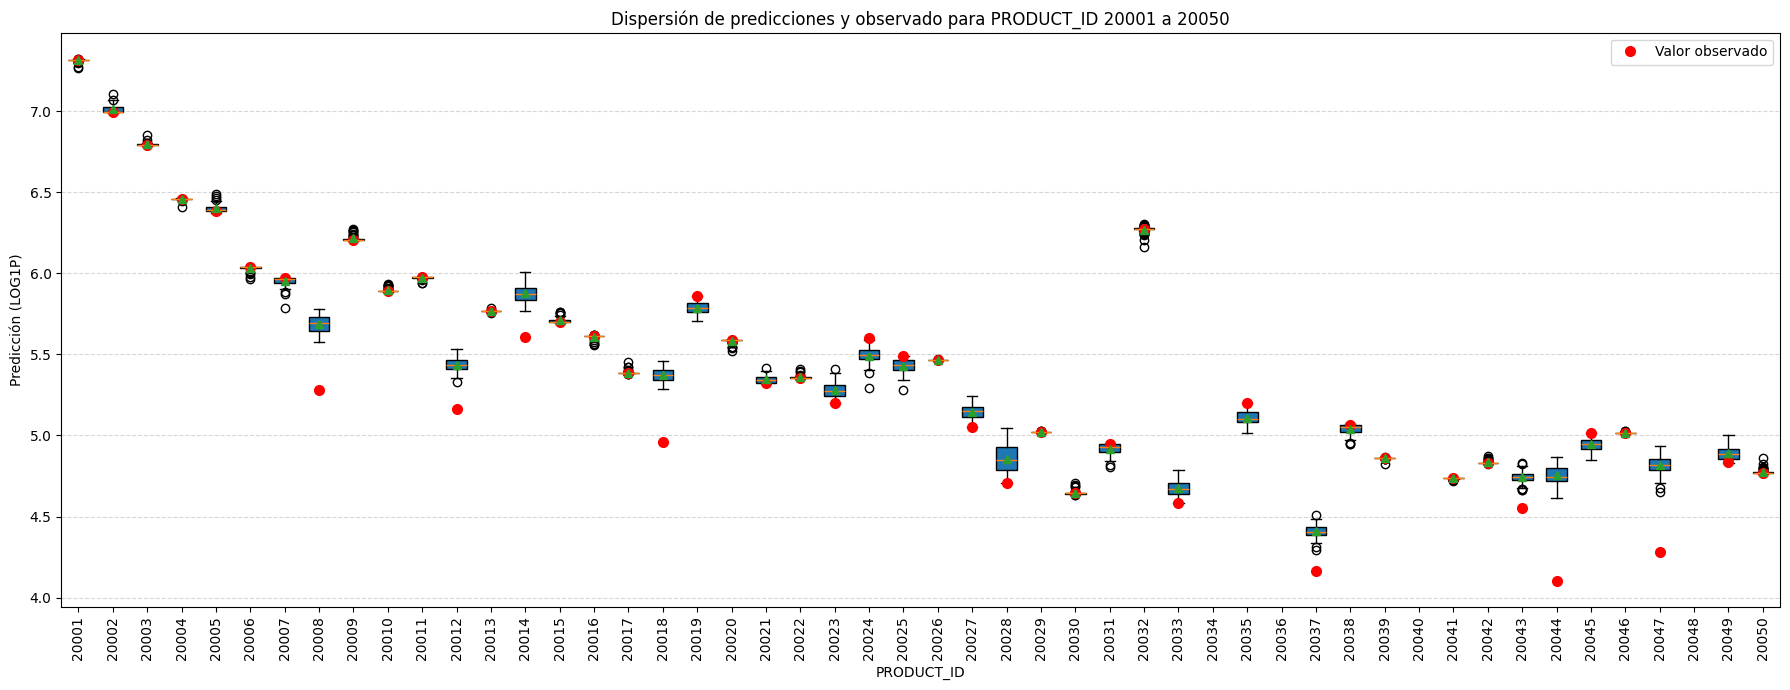

In [17]:
import matplotlib.pyplot as plt

# Rango de productos a analizar
productos = range(20001, 20051)

plt.figure(figsize=(18, 7))

box_data = []
obs_pos = []
obs_vals = []

for i, pid in enumerate(productos, 1):
    # Todas las predicciones fila a fila para ese producto
    vals = df_test[df_test['PRODUCT_ID'] == pid][lgbm_pred_cols].values.flatten()
    box_data.append(vals)
    # Todos los valores observados para ese producto
    vals_obs = df_test[df_test['PRODUCT_ID'] == pid]['CLASE_LOG1P'].values
    for obs in vals_obs:
        obs_pos.append(i)
        obs_vals.append(obs)

# Dibujar los boxplots
plt.boxplot(box_data, positions=range(1, len(productos)+1), widths=0.6, patch_artist=True, showmeans=True)

# Dibujar todos los valores observados como círculos rojos
plt.plot(obs_pos, obs_vals, 'ro', markersize=7, label='Valor observado')

plt.title('Dispersión de predicciones y observado para PRODUCT_ID 20001 a 20050')
plt.ylabel('Predicción (LOG1P)')
plt.xlabel('PRODUCT_ID')
plt.xticks(range(1, len(productos)+1), [str(pid) for pid in productos], rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()




/tmp/ipykernel_43344/4101327305.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.T, labels=df_plot['PRODUCT_ID'], showfliers=True)


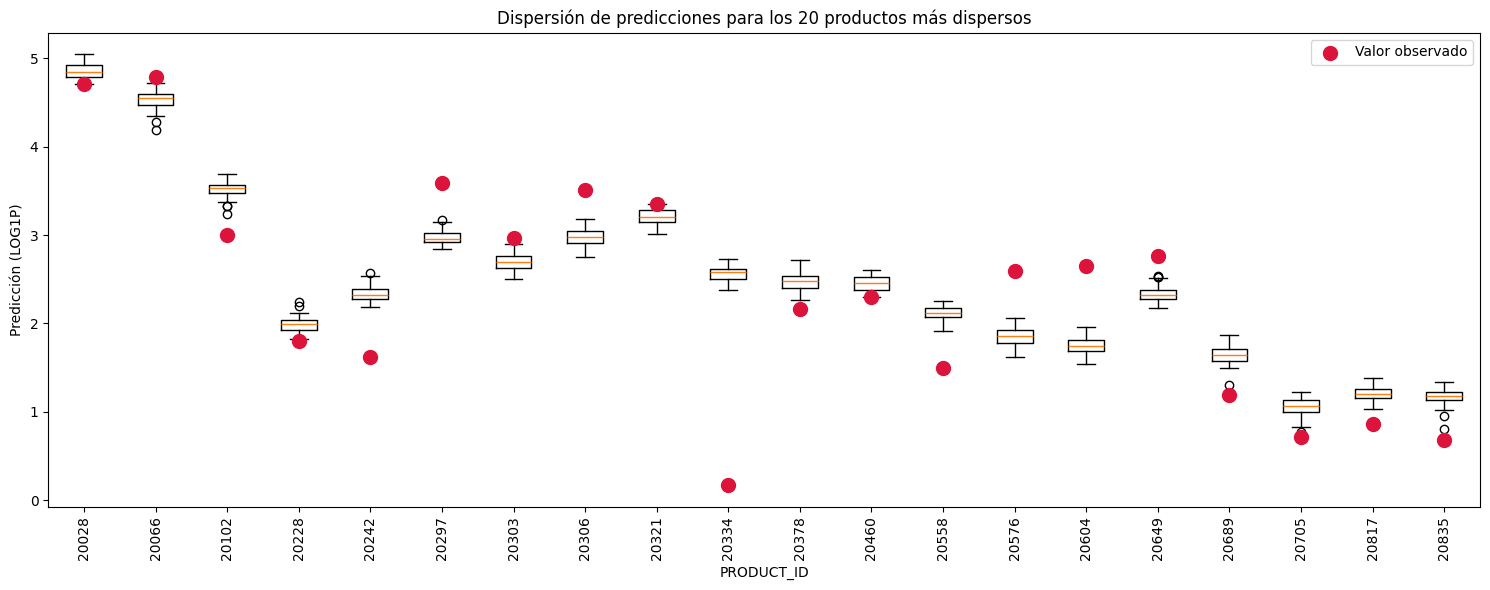

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calcula la dispersión (std) para cada producto
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_')]
df_test['pred_std'] = df_test[pred_cols].std(axis=1)
top_n = 20
productos_disp = df_test.sort_values('pred_std', ascending=False)['PRODUCT_ID'].unique()[:top_n]

# Subset de los productos seleccionados
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()
df_plot = df_plot[['PRODUCT_ID', 'CLASE_LOG1P'] + pred_cols]

# Boxplots
plt.figure(figsize=(15, 6))
data = df_plot[pred_cols].values  # Solo las columnas de predicción
positions = np.arange(1, len(df_plot)+1)

plt.boxplot(data.T, labels=df_plot['PRODUCT_ID'], showfliers=True)

# Marcar el valor observado con un punto rojo para cada producto
for idx, (prod, y_true) in enumerate(zip(df_plot['PRODUCT_ID'], df_plot['CLASE_LOG1P'])):
    plt.scatter(idx+1, y_true, color='crimson', marker='o', s=100, zorder=5, label='Valor observado' if idx==0 else "")

plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (LOG1P)')
plt.title(f'Dispersión de predicciones para los {top_n} productos más dispersos')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



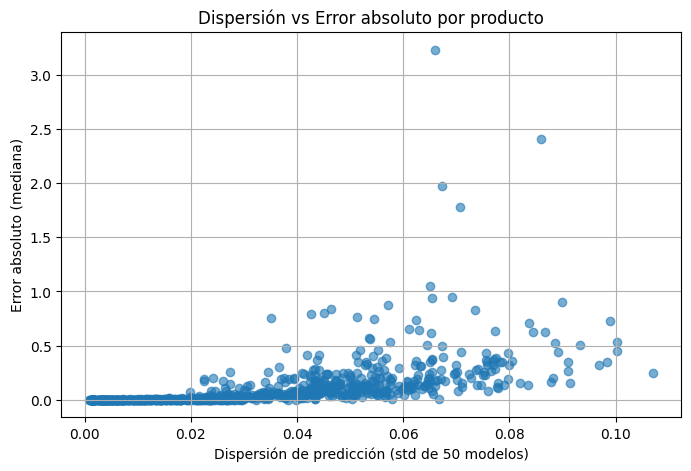

In [19]:
# Calcula la predicción central y la dispersión
df_test['pred_median'] = df_test[pred_cols].median(axis=1)
df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
df_test['pred_std'] = df_test[pred_cols].std(axis=1)

# Error absoluto respecto al real
df_test['abs_err_median'] = (df_test['pred_median'] - df_test['CLASE_LOG1P']).abs()
df_test['abs_err_mean'] = (df_test['pred_mean'] - df_test['CLASE_LOG1P']).abs()

plt.figure(figsize=(8,5))
plt.scatter(df_test['pred_std'], df_test['abs_err_median'], alpha=0.6)
plt.xlabel('Dispersión de predicción (std de 50 modelos)')
plt.ylabel('Error absoluto (mediana)')
plt.title('Dispersión vs Error absoluto por producto')
plt.grid(True)
plt.show()


In [20]:
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_')]
df_test['CLASE_TN'] = inv_transform_log1p(df_test['CLASE_LOG1P'].values)
# Tomar las 50 columnas como una matriz
preds_scaled = df_test[pred_cols].values  # shape (n, 50)
# Invertir la transformación para cada columna
preds_inv = preds_scaled  # shape (n, 50)
preds_orig = inv_transform_log1p(preds_inv)  # Deshace log1p

# Crear nuevas columnas en el DataFrame con los valores originales
for i, col in enumerate(pred_cols):
    df_test[col.replace('LOG1P', 'TN')] = preds_orig[:, i]


/tmp/ipykernel_43344/4261386060.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_43344/4261386060.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_43344/4261386060.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [21]:
# Las nuevas columnas de predicción en escala original
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]
df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
df_test['abs_error_median_tn'] = np.abs(df_test['pred_median_tn'] - df_test['CLASE_TN'])


/tmp/ipykernel_43344/2174904353.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
/tmp/ipykernel_43344/2174904353.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
/tmp/ipykernel_43344/2174904353.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

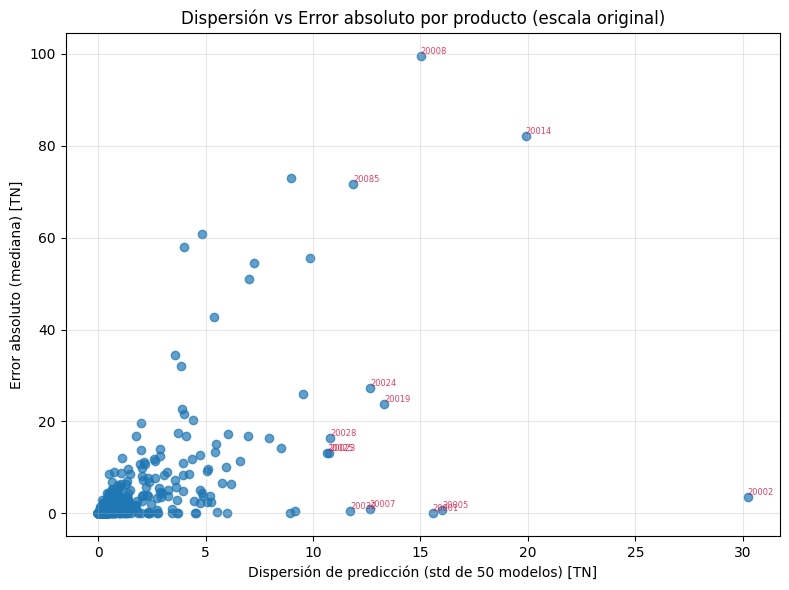

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_test['pred_std_tn'], df_test['abs_error_median_tn'], alpha=0.7)

# Etiquetar solo los puntos más dispersos
umbral_disp = 10  # Cambia el umbral si querés más o menos etiquetas
df_label = df_test[df_test['pred_std_tn'] > umbral_disp]

for _, row in df_label.iterrows():
    plt.text(
        row['pred_std_tn'],
        row['abs_error_median_tn'],
        f"{int(row['PRODUCT_ID'])}",  # fuerza a int sin decimales
        fontsize=6,                  # más pequeño
        color='crimson',
        alpha=0.8,
        ha='left',
        va='bottom'
    )

plt.xlabel('Dispersión de predicción (std de 50 modelos) [TN]')
plt.ylabel('Error absoluto (mediana) [TN]')
plt.title('Dispersión vs Error absoluto por producto (escala original)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




/tmp/ipykernel_43344/1523536016.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


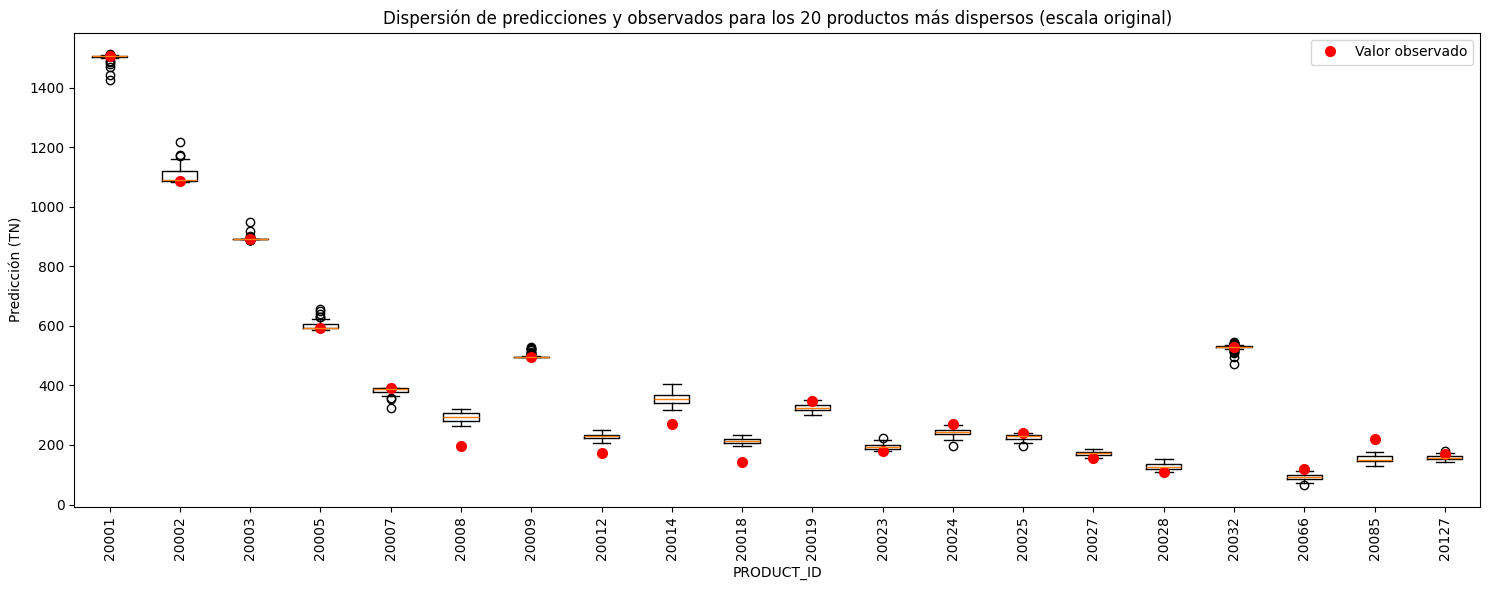

In [23]:
import matplotlib.pyplot as plt

# Top N más dispersos
top_n = 20
productos_disp = df_test.sort_values('pred_std_tn', ascending=False)['PRODUCT_ID'].unique()[:top_n]
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()

plt.figure(figsize=(15, 6))

# Armar datos para el boxplot
data = [row[1:] for row in df_plot[['PRODUCT_ID'] + pred_cols_tn].values]  # omite PRODUCT_ID
labels = df_plot['PRODUCT_ID'].astype(str).values

# Plotear los boxplots
plt.boxplot(data, labels=labels, showfliers=True)

# Sobreponer los valores observados (puede haber más de uno por producto, si hay varias filas)
for idx, prod_id in enumerate(df_plot['PRODUCT_ID']):
    valores_reales = df_test[df_test['PRODUCT_ID'] == prod_id]['CLASE_TN'].values
    for vreal in valores_reales:
        plt.plot(idx + 1, vreal, 'ro', markersize=7, label='Valor observado' if idx == 0 else "")

plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (TN)')
plt.title(f'Dispersión de predicciones y observados para los {top_n} productos más dispersos (escala original)')

# Mostrar solo un label para 'Valor observado'
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend([handles[0]], ['Valor observado'])

plt.tight_layout()
plt.show()



In [24]:
top_n = 30

# Top por dispersión
top_disp = df_test.sort_values('pred_std_tn', ascending=False).head(top_n)
print("Top 30 productos por dispersión:")
print(top_disp[['PRODUCT_ID', 'pred_std_tn', 'abs_error_median_tn', 'CLASE_TN']])

# Top por error absoluto
top_error = df_test.sort_values('abs_error_median_tn', ascending=False).head(top_n)
print("\nTop 30 productos por error absoluto:")
print(top_error[['PRODUCT_ID', 'pred_std_tn', 'abs_error_median_tn', 'CLASE_TN']])



Top 30 productos por dispersión:
      PRODUCT_ID  pred_std_tn  abs_error_median_tn    CLASE_TN
38         20002    30.222380             3.638243  1087.30855
470        20014    19.896802            82.153920   272.02812
146        20005    15.998941             0.746056   592.53573
2          20001    15.575154             0.008369  1504.68856
254        20008    15.007146            99.613375   195.36854
650        20019    13.317509            23.739726   349.22330
830        20024    12.666141            27.243192   270.31914
218        20007    12.633175             0.909009   390.43432
2706       20085    11.871271            71.791353   221.56404
1118       20032    11.724917             0.507564   527.79811
974        20028    10.797148            16.308411   109.92618
794        20023    10.750999            13.111252   180.58677
866        20025    10.649100            13.038061   241.70328
398        20012     9.848304            55.610731   173.13004
2094       20066     9

In [25]:
import numpy as np
import pandas as pd

# 1. Identificá las columnas de predicción
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]

# 2. Calculá media y mediana de las predicciones
df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)

# 3. Calculá el MAE para ambas estrategias
mae_median = np.mean(np.abs(df_test['ensemble_median'] - df_test['CLASE_TN']))
mae_mean   = np.mean(np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN']))

print(f"MAE usando la **mediana** de 50 modelos: {mae_median:.3f} TN")
print(f"MAE usando la **media** de 50 modelos:   {mae_mean:.3f} TN")

# 4. Si querés comparar producto por producto:
df_test['error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])
df_test['error_mean']   = np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN'])

print("\nTop 10 productos donde la media le gana a la mediana:")
print(df_test[df_test['error_mean'] < df_test['error_median']][['PRODUCT_ID', 'error_median', 'error_mean']].sort_values('error_median', ascending=False).head(10))


MAE usando la **mediana** de 50 modelos: 2.449 TN
MAE usando la **media** de 50 modelos:   2.577 TN

Top 10 productos donde la media le gana a la mediana:
      PRODUCT_ID  error_median  error_mean
254        20008     99.613375   98.794075
614        20018     72.941703   72.805867
2706       20085     71.791353   69.473519
398        20012     55.610731   55.245053
2310       20072     42.769004   42.287871
2490       20077     22.779718   22.486399
2238       20070     21.654610   21.473836
1381       20043     20.349449   20.007706
1842       20057     17.193460   15.949360
3629       20119     16.939171   16.914823


/tmp/ipykernel_43344/245051272.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
/tmp/ipykernel_43344/245051272.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)
/tmp/ipykernel_43344/245051272.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

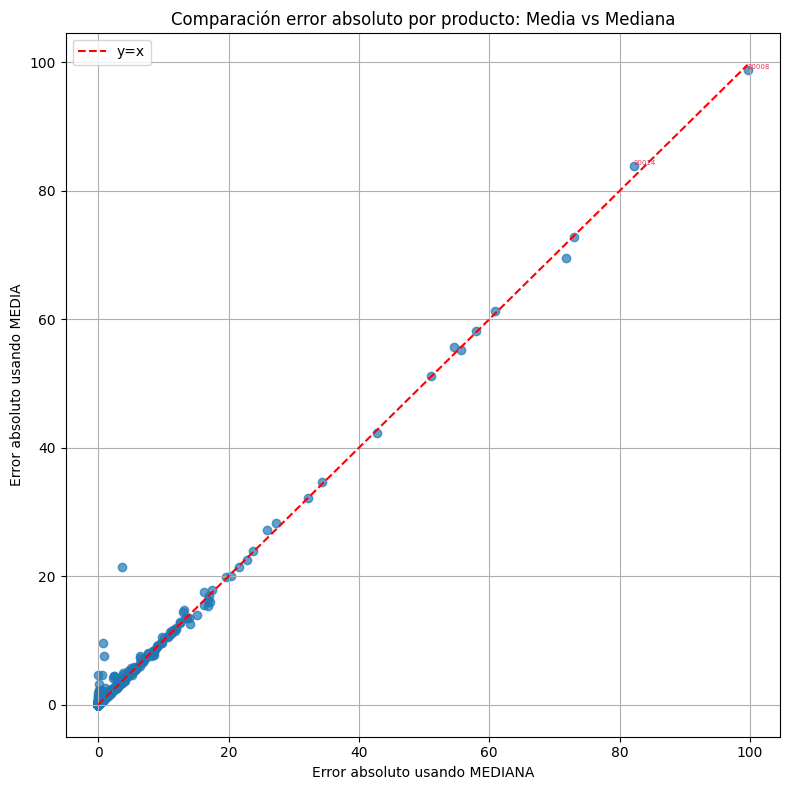

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(df_test['error_median'], df_test['error_mean'], alpha=0.7)

plt.plot(
    [df_test['error_median'].min(), df_test['error_median'].max()],
    [df_test['error_median'].min(), df_test['error_median'].max()],
    'r--', label='y=x'
)

# Etiquetar PRODUCT_ID donde error_median > 75 o error_mean > 75
for _, row in df_test.iterrows():
    if row['error_median'] > 75 or row['error_mean'] > 75:
        plt.text(
            row['error_median'],
            row['error_mean'],
            str(int(row['PRODUCT_ID'])),
            fontsize=5,
            color='crimson',
            alpha=0.85,
            ha='left',
            va='bottom'
        )

plt.xlabel('Error absoluto usando MEDIANA')
plt.ylabel('Error absoluto usando MEDIA')
plt.title('Comparación error absoluto por producto: Media vs Mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



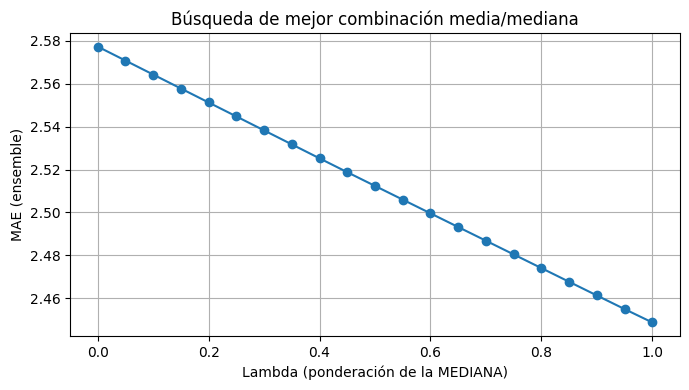

Mejor lambda = 1.00 (MAE=2.449 TN)


In [27]:
import numpy as np

lambdas = np.linspace(0, 1, 21)
maes = []

for l in lambdas:
    pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    mae = np.mean(np.abs(pred - df_test['CLASE_TN']))
    maes.append(mae)

plt.figure(figsize=(7, 4))
plt.plot(lambdas, maes, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('MAE (ensemble)')
plt.title('Búsqueda de mejor combinación media/mediana')
plt.grid(True)
plt.tight_layout()
plt.show()

best_lambda = lambdas[np.argmin(maes)]
print(f"Mejor lambda = {best_lambda:.2f} (MAE={min(maes):.3f} TN)")


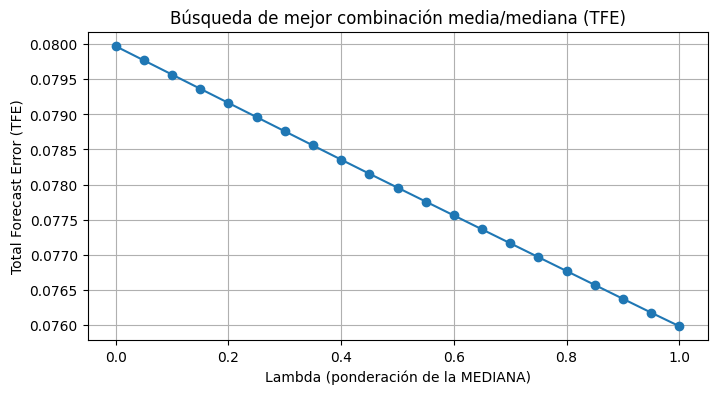

Mejor lambda: 1.00  ->  TFE = 0.075979


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Tu función de métrica
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador 

# Suponiendo que en tu df_test ya tenés:
# 'ensemble_median', 'ensemble_mean', y la observación real 'CLASE_TN'
lambdas = np.linspace(0, 1, 21)
tfe_scores = []

for l in lambdas:
    y_pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    tfe = total_forecast_error(df_test['CLASE_TN'].values, y_pred.values)
    tfe_scores.append(tfe)

plt.figure(figsize=(8, 4))
plt.plot(lambdas, tfe_scores, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('Total Forecast Error (TFE)')
plt.title('Búsqueda de mejor combinación media/mediana (TFE)')
plt.grid(True)
plt.show()

# Mejor lambda encontrado y su TFE
best_idx = np.argmin(tfe_scores)
print(f"Mejor lambda: {lambdas[best_idx]:.2f}  ->  TFE = {tfe_scores[best_idx]:.6f}")


In [ ]:
print(df_test.columns.tolist())

In [29]:
import pandas as pd
import numpy as np

# Si ensemble_median es UNA predicción por producto (no por fila):
# Entonces podés hacer así, suponiendo que tenés una única fila por PRODUCT_ID en df_test:
df_test['abs_error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])

# Ordenar por el error absoluto de la mediana, descendente (de mayor a menor error)
df_ordenado = df_test.sort_values('abs_error_median', ascending=False)[['PRODUCT_ID', 'ensemble_median', 'CLASE_TN', 'abs_error_median']]

print(df_ordenado.head(50))


       PRODUCT_ID  ensemble_median   CLASE_TN  abs_error_median
254         20008       294.981915  195.36854         99.613375
470         20014       354.182040  272.02812         82.153920
614         20018       214.577403  141.63570         72.941703
2706        20085       149.772687  221.56404         71.791353
2562        20080        69.727842    8.84426         60.883582
3135        20100        59.355046    1.37920         57.975846
398         20012       228.740771  173.13004         55.610731
1417        20044       114.151537   59.61747         54.534067
1525        20047       122.446528   71.42762         51.018908
2310        20072        75.037604   32.26860         42.769004
4271        20143        64.304855   29.92779         34.377065
2991        20095        60.645535   28.52853         32.117005
830         20024       243.075948  270.31914         27.243192
2094        20066        93.353738  119.28134         25.927602
650         20019       325.483574  349.

/tmp/ipykernel_43344/4196542951.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['abs_error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])


In [30]:
# Calcula el TFE por producto usando media y mediana
tfe_prod_median = []
tfe_prod_mean = []

for pid, subdf in df_test.groupby('PRODUCT_ID'):
    tfe_median = total_forecast_error(subdf['CLASE_TN'].values, subdf['ensemble_median'].values)
    tfe_mean = total_forecast_error(subdf['CLASE_TN'].values, subdf['ensemble_mean'].values)
    tfe_prod_median.append((pid, tfe_median))
    tfe_prod_mean.append((pid, tfe_mean))

df_tfe = pd.DataFrame({
    'PRODUCT_ID': [pid for pid, _ in tfe_prod_median],
    'TFE_median': [tfe for _, tfe in tfe_prod_median],
    'TFE_mean': [tfe for _, tfe in tfe_prod_mean]
})
df_tfe['TFE_diff'] = df_tfe['TFE_median'] - df_tfe['TFE_mean']

# Top 10 productos donde la media mejora más vs la mediana
print(df_tfe.sort_values('TFE_diff', ascending=False).head(10))


     PRODUCT_ID  TFE_median   TFE_mean  TFE_diff
273       20334   64.305302  63.132092  1.173210
532       20721   13.167516  13.020041  0.147474
385       20503   10.780383  10.667405  0.112978
490       20660    7.063252   6.995513  0.067739
603       20852    1.468289   1.412262  0.056027
376       20484    2.602631   2.564752  0.037880
712       21088    0.558901   0.527288  0.031613
386       20505    3.154892   3.126130  0.028762
91        20102    0.730312   0.704859  0.025453
594       20832    6.395642   6.370714  0.024928


In [34]:
# Calcular el TFE total para el conjunto de test
tfe_total_median = total_forecast_error(df_test['CLASE_TN'].values, df_test['ensemble_median'].values)
tfe_total_mean = total_forecast_error(df_test['CLASE_TN'].values, df_test['ensemble_mean'].values)
print(f"TFE total usando mediana: {tfe_total_median:.6f}")
print(f"TFE total usando media: {tfe_total_mean:.6f}")
print(np.sum(df_test['CLASE_TN'].values))  # Para verificar el denominador de TFE

TFE total usando mediana: 0.075979
TFE total usando media: 0.079973
25137.681330000003


In [35]:
# Top productos donde la mediana es mejor que la media
print(df_tfe[df_tfe['TFE_diff'] < 0].sort_values('TFE_diff').head(10))


     PRODUCT_ID  TFE_median    TFE_mean  TFE_diff
705       21074  367.256976  370.169120 -2.912145
779       21276    0.045800    0.189757 -0.143957
769       21246    0.063691    0.206807 -0.143116
89        20100   42.035851   42.164287 -0.128436
746       21180    0.467609    0.593373 -0.125764
747       21182    0.000539    0.120040 -0.119501
741       21168    0.022579    0.102962 -0.080382
716       21099    0.000612    0.066850 -0.066238
321       20398    0.016011    0.080127 -0.064116
533       20724    0.010078    0.072559 -0.062480


In [48]:
X_full = pd.concat([df_train, df_val,df_test], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col],df_test[target_col]], ignore_index=True)
df_pred = df_pred = df_full[df_full['PERIODO'] == 201912].copy()

In [37]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"

results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")


Entrenando modelo 2/50...
Entrenando modelo 1/50...
Entrenando modelo 3/50...
Entrenando modelo 5/50...
Entrenando modelo 6/50...
Entrenando modelo 8/50...
Entrenando modelo 4/50...
Entrenando modelo 11/50...
Entrenando modelo 9/50...
Entrenando modelo 13/50...
Entrenando modelo 12/50...
Entrenando modelo 16/50...
Entrenando modelo 7/50...
Entrenando modelo 17/50...
Entrenando modelo 14/50...
Entrenando modelo 15/50...
Entrenando modelo 10/50...
Entrenando modelo 19/50...
Entrenando modelo 20/50...
Entrenando modelo 18/50...
Entrenando modelo 21/50...
Entrenando modelo 22/50...
Entrenando modelo 23/50...
Entrenando modelo 24/50...
Entrenando modelo 25/50...
Entrenando modelo 26/50...
Entrenando modelo 27/50...
Entrenando modelo 28/50...
Entrenando modelo 29/50...
Entrenando modelo 30/50...
Entrenando modelo 31/50...
Entrenando modelo 32/50...
Entrenando modelo 33/50...
Entrenando modelo 34/50...
Entrenando modelo 35/50...
Entrenando modelo 36/50...
Entrenando modelo 37/50...
Entrenando

In [49]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)

In [39]:
print(df_pred.columns.tolist())

['ORDINAL', 'PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID', 'TN', 'MES_PROBLEMATICO', 'IS_FEBRERO', 'ESTOY_PREDICIENDO_FEBRERO', 'CAIDA_ABRUPTA', 'PROM_ULT_3_FEBREROS', 'DIF_TN_VS_FEBREROS_ULT_3', 'TN_MAX_HISTORICO', 'TN_DIST_A_MAX_HIST', 'TN_RATIO_VS_MAX_HIST', 'TN_MEAN_03', 'PENDIENTE_TENDENCIA_3', 'TN_EWMA_03', 'TN_MEDIAN_03', 'TN_MIN_03', 'TN_MAX_03', 'TN_STD_03', 'TN_SKEW_03', 'TN_KURT_03', 'TN_GROWTH_03', 'TN_IQR_03', 'TN_SUM_03', 'TN_COUNT_POS_03', 'TN_PCT_ZERO_03', 'TN_LAST_03', 'TN_LAST_DIFF_03', 'TN_COEF_VAR_3', 'TN_MAXMIN_RATIO_3', 'TN_RANGO_3', 'TN_RANGO_REL_3', 'TN_LAST_VS_MEDIAN_3', 'TN_CHANGE_PREV_WINDOW_3', 'TN_ZEROS_END_3', 'TN_LAST_PCT_SUM_3', 'TN_PCT90_3', 'TN_PCT10_3', 'TN_PCT_WIDTH_3', 'TN_MINUS_MEAN_03', 'TN_MINUS_MEDIAN_03', 'TN_MINUS_EWMA_03', 'TN_OVER_MEAN_03', 'TN_OVER_MEDIAN_03', 'TN_OVER_EWMA_03', 'TN_MEAN_06', 'PENDIENTE_TENDENCIA_6', 'TN_EWMA_06', 'TN_MEDIAN_06', 'TN_MIN_06

In [50]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_pred.columns if col != target_col]

X_pred_lgbm = df_pred[feature_cols]  

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_pred[f'lgbm_pred_LOG1P_{i+1}'] = lgbm_preds[:, i]


Prediciendo LightGBM 1/50...
Prediciendo LightGBM 2/50...
Prediciendo LightGBM 3/50...
Prediciendo LightGBM 4/50...
Prediciendo LightGBM 5/50...
Prediciendo LightGBM 6/50...
Prediciendo LightGBM 7/50...
Prediciendo LightGBM 8/50...
Prediciendo LightGBM 9/50...
Prediciendo LightGBM 10/50...
Prediciendo LightGBM 11/50...
Prediciendo LightGBM 12/50...
Prediciendo LightGBM 13/50...
Prediciendo LightGBM 14/50...
Prediciendo LightGBM 15/50...
Prediciendo LightGBM 16/50...
Prediciendo LightGBM 17/50...
Prediciendo LightGBM 18/50...
Prediciendo LightGBM 19/50...
Prediciendo LightGBM 20/50...
Prediciendo LightGBM 21/50...
Prediciendo LightGBM 22/50...
Prediciendo LightGBM 23/50...
Prediciendo LightGBM 24/50...
Prediciendo LightGBM 25/50...
Prediciendo LightGBM 26/50...
Prediciendo LightGBM 27/50...
Prediciendo LightGBM 28/50...
Prediciendo LightGBM 29/50...
Prediciendo LightGBM 30/50...
Prediciendo LightGBM 31/50...
Prediciendo LightGBM 32/50...
Prediciendo LightGBM 33/50...
Prediciendo LightGB

In [51]:
print(df_pred.columns.tolist())

['ORDINAL', 'PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID', 'TN', 'MES_PROBLEMATICO', 'IS_FEBRERO', 'ESTOY_PREDICIENDO_FEBRERO', 'CAIDA_ABRUPTA', 'PROM_ULT_3_FEBREROS', 'DIF_TN_VS_FEBREROS_ULT_3', 'TN_MAX_HISTORICO', 'TN_DIST_A_MAX_HIST', 'TN_RATIO_VS_MAX_HIST', 'TN_MEAN_03', 'PENDIENTE_TENDENCIA_3', 'TN_EWMA_03', 'TN_MEDIAN_03', 'TN_MIN_03', 'TN_MAX_03', 'TN_STD_03', 'TN_SKEW_03', 'TN_KURT_03', 'TN_GROWTH_03', 'TN_IQR_03', 'TN_SUM_03', 'TN_COUNT_POS_03', 'TN_PCT_ZERO_03', 'TN_LAST_03', 'TN_LAST_DIFF_03', 'TN_COEF_VAR_3', 'TN_MAXMIN_RATIO_3', 'TN_RANGO_3', 'TN_RANGO_REL_3', 'TN_LAST_VS_MEDIAN_3', 'TN_CHANGE_PREV_WINDOW_3', 'TN_ZEROS_END_3', 'TN_LAST_PCT_SUM_3', 'TN_PCT90_3', 'TN_PCT10_3', 'TN_PCT_WIDTH_3', 'TN_MINUS_MEAN_03', 'TN_MINUS_MEDIAN_03', 'TN_MINUS_EWMA_03', 'TN_OVER_MEAN_03', 'TN_OVER_MEDIAN_03', 'TN_OVER_EWMA_03', 'TN_MEAN_06', 'PENDIENTE_TENDENCIA_6', 'TN_EWMA_06', 'TN_MEDIAN_06', 'TN_MIN_06

In [52]:
pred_cols = [c for c in df_pred.columns if c.startswith('lgbm_pred_LOG1P_')]
df_pred['CLASE_TN'] = inv_transform_log1p(df_pred['CLASE_LOG1P'].values)
# Tomar las 50 columnas como una matriz
preds_inv = df_pred[pred_cols].values  # shape (n, 50)
# Invertir la transformación para cada columna
preds_orig = inv_transform_log1p(preds_inv)  # Deshace log1p

# Crear nuevas columnas en el DataFrame con los valores originales
for i, col in enumerate(pred_cols):
    df_pred[col.replace('LOG1P', 'TN')] = preds_orig[:, i]


/tmp/ipykernel_43344/1419986256.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_43344/1419986256.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_43344/1419986256.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [53]:
# Eliminar de df_preds_final las columnas con "_LOG1P_Z_"
cols_to_remove = [col for col in df_pred.columns if '_LOG1P_' in col]
df_pred.drop(columns=cols_to_remove, inplace=True)

In [57]:
lgbm_cols = [c for c in df_pred.columns if c.startswith('lgbm_pred_TN')]
print(lgbm_cols)

['lgbm_pred_TN_1', 'lgbm_pred_TN_2', 'lgbm_pred_TN_3', 'lgbm_pred_TN_4', 'lgbm_pred_TN_5', 'lgbm_pred_TN_6', 'lgbm_pred_TN_7', 'lgbm_pred_TN_8', 'lgbm_pred_TN_9', 'lgbm_pred_TN_10', 'lgbm_pred_TN_11', 'lgbm_pred_TN_12', 'lgbm_pred_TN_13', 'lgbm_pred_TN_14', 'lgbm_pred_TN_15', 'lgbm_pred_TN_16', 'lgbm_pred_TN_17', 'lgbm_pred_TN_18', 'lgbm_pred_TN_19', 'lgbm_pred_TN_20', 'lgbm_pred_TN_21', 'lgbm_pred_TN_22', 'lgbm_pred_TN_23', 'lgbm_pred_TN_24', 'lgbm_pred_TN_25', 'lgbm_pred_TN_26', 'lgbm_pred_TN_27', 'lgbm_pred_TN_28', 'lgbm_pred_TN_29', 'lgbm_pred_TN_30', 'lgbm_pred_TN_31', 'lgbm_pred_TN_32', 'lgbm_pred_TN_33', 'lgbm_pred_TN_34', 'lgbm_pred_TN_35', 'lgbm_pred_TN_36', 'lgbm_pred_TN_37', 'lgbm_pred_TN_38', 'lgbm_pred_TN_39', 'lgbm_pred_TN_40', 'lgbm_pred_TN_41', 'lgbm_pred_TN_42', 'lgbm_pred_TN_43', 'lgbm_pred_TN_44', 'lgbm_pred_TN_45', 'lgbm_pred_TN_46', 'lgbm_pred_TN_47', 'lgbm_pred_TN_48', 'lgbm_pred_TN_49', 'lgbm_pred_TN_50']


In [58]:
df_pred['lgbm_mean'] = df_pred[lgbm_cols].mean(axis=1)
df_pred['lgbm_median'] = df_pred[lgbm_cols].median(axis=1)

In [59]:
df_pred['lgbm_mean'] = df_pred['lgbm_mean'].clip(lower=0)
df_pred['lgbm_media'] = df_pred['lgbm_median'].clip(lower=0)


df_pred[['PRODUCT_ID', 'lgbm_mean']]\
    .rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_mean': 'tn'})\
    .to_csv('lgbm_predictions_mean.csv', index=False)

df_pred[['PRODUCT_ID', 'lgbm_median']]\
    .rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_median': 'tn'})\
    .to_csv('lgbm_predictions_median.csv', index=False)

